# Placeholder heading

In [1]:
import numpy as np
from numpy import sqrt
from matplotlib import pyplot as plt
from scipy import integrate


In [2]:
import os

cd = os.path.dirname(os.path.abspath("./"))
print(cd)  # check correct path


c:\University\PHYS3080\Project_Cosmological-Project


In [3]:
c = 299792.458  # km/s (speed of light)

H0kmsmpc = 70.0  # Hubble constant in km/s/Mpc
H0s = (
    H0kmsmpc * 3.2408e-20
)  # H0 in inverse seconds is H0 in km/s/Mpc * (3.2408e-20 Mpc/km)
H0y = (
    H0s * 3.154e7 * 1.0e9
)  # H0 in inverse Gigayears is H0 in inverse seconds * (3.154e7 seconds/year) * (1e9 years / gigayear)
print("Hubble time = ", 1 / H0y, "Gyr")

# Let's format that to a more appropriate number of significant figures.
# The first % means put the variable here.  The .2f means make it a float with 2 decimal places.
print("Hubble time = %.2f Gyr" % (1 / H0y))


Hubble time =  13.976165695516954 Gyr
Hubble time = 13.98 Gyr


In [4]:
# First write a function that takes as input a, Omega_M (om), and Omega_Lambda (ol) and outputs 1/adot
def adotinv(a, om, ol) -> float:
    """Return reciprocal of da/dt given a, Omega_M, Omega_Lambda."""
    ok = 1 - om - ol
    adot = a * sqrt(om * 1 / (a**3) + ok * 1 / (a**2) + ol)
    return 1.0 / adot


In [9]:
def saveFigure(fig, dirname, filename):
    # handy function
    s = f"{cd}/FitModels/plots/{dirname}/{filename}"
    fig.savefig(
        f"{s}.png",
        transparent=False,
        facecolor="w",
    )
    fig.savefig(
        f"{s}.pdf",
        transparent=False,
        facecolor="w",
    )


Here we specialise to data set 1. If you want to analyse a different data set, copy the corresponding parameters.txt and comment out the $\chi^2$ line (as it does not format correctly for direct pasting). 

In [10]:
dirname = "Data1"
(om,ol)=(0.21212121212121213,0.3434343434343435)
# Reduced chi^2 = 1.1202092711239662
sd_lower_l=0.20202020202020204
sd_upper_l=0.4646464646464647
sd_lower_m=0.14141414141414144
sd_upper_m=0.27272727272727276

In [11]:
astep = 0.001  # Make this finer to make the plot smoother
astart = astep
astop = 10
a_arr = np.arange(astart, astop, astep)


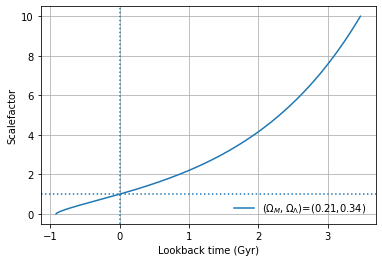

In [12]:
# Note that when you integrate something with more than one argument you pass it with args=(arg1,arg2) in the integrate function
# e.g. "integrate.quad(adotinv, lower_limit, upper_limit, args=(om,ol))""
t_today_Gyr, _ = integrate.quad(adotinv, 0, 1, args=(om, ol))
t_Gyr = np.array(
    [integrate.quad(adotinv, 0, a_end, args=(om, ol))[0] for a_end in a_arr[1:]]
)
# slice [1:] to avoid division by zero error
t_lookback_Gyr = t_Gyr - t_today_Gyr

# Plot this new model
fig, ax = plt.subplots()
# slice a_arr [1:] for same reason as t_Gyr slice
ax.plot(
    t_lookback_Gyr, a_arr[1:], label=f"($\Omega_M,\Omega_\Lambda$)=({om:.2f},{ol:.2f})"
)
ax.axvline(x=0, linestyle=":")  # Plot some crosshairs
ax.axhline(y=1, linestyle=":")
ax.set_xlabel("Lookback time (Gyr)")
ax.set_ylabel("Scalefactor")
ax.grid()
ax.legend(loc="lower right", frameon=False)
saveFigure(fig, dirname, "scalefactor_evolution")


In [16]:
def Sk(xx, ok):
    """
    You may find this function useful to calculate the perpendicular comoving distance R0*Sk(X)
        Corrects the comoving distance, xx, for curvature, ok.
        Result is perpendicular comoving distance / (c/H0)
        i.e. it's the distance to use in angular diameter and luminosity distance

    This returns a value for R_0S_k(\chi) that you multiply by c/H_0 to give it units.
    """
    if ok < 0.0:
        return np.sin(np.sqrt(-ok) * xx) / np.sqrt(-ok)
    elif ok > 0.0:
        return np.sinh(np.sqrt(ok) * xx) / np.sqrt(ok)
    else:
        return xx


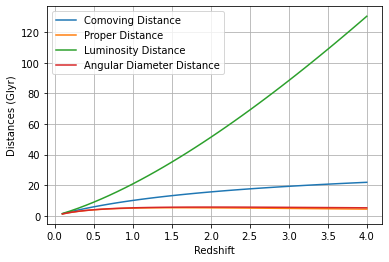

In [17]:
c = 299792.458  # km/s (speed of light)

H0kmsmpc = 70.0  # Hubble constant in km/s/Mpc
cH0mpc = (
    c / H0kmsmpc
)  # c/H0 in Mpc  (the km/s cancel out in the numerator and denominator)
cH0Glyr = (
    cH0mpc * 3.262 / 1000
)  # c/H0 in billions of light years.  There are 3.262 light year / parsec


def Ez(z, om_r, om_m, om_l):
    om_k = 1 - om_r - om_m - om_l
    return np.sqrt(
        om_r * (1 + z) ** 4 + om_m * (1 + z) ** 3 + om_k * (1 + z) ** 2 + om_l
    )


def integrand(z, om_r, om_m, om_l):
    return 1 / Ez(z, om_r, om_m, om_l)


zstep = 0.1  # Make this finer to make the plot smoother
zstart = zstep
zstop = 4 + zstep
z_arr = np.arange(zstart, zstop, zstep)

myIntegrand = lambda x: integrand(x, 0, om, ol)
# xx_arr = np.array([integrate.quad(integrand,1,z, args=(0, om, ol))[0] for z in z_arr])
xx_arr = np.array([integrate.quad(myIntegrand, 0, z)[0] for z in z_arr])

R0X_arr = xx_arr * cH0Glyr

ok = 1 - om - ol
DD = R0X_arr  # comoving distance
DDD = R0X_arr / (1 + z_arr)  # proper distance
# Luminosity distance
DL = Sk(xx_arr, ok) * (1 + z_arr) * cH0Glyr
# Angular diameter distance
# DL = Sk(xx_arr, ok) / (1 + z_arr) * cH0Glyr
DA = DL / ((1 + z_arr) ** 2)

fig, ax = plt.subplots()
ax.plot(z_arr, DD, label="Comoving Distance")
ax.plot(z_arr, DDD, label="Proper Distance")
ax.plot(z_arr, DL, label="Luminosity Distance")
ax.plot(z_arr, DA, label="Angular Diameter Distance")
ax.legend()
ax.grid()
ax.set_xlabel("Redshift")
ax.set_ylabel("Distances (Glyr)")
saveFigure(fig, dirname, "distances")


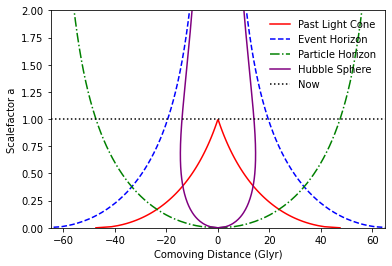

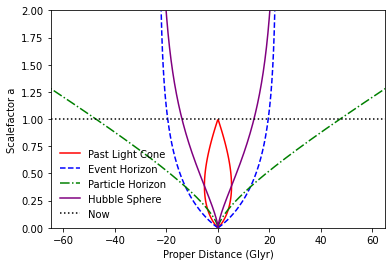

In [20]:
### Copied from Jayden's code
# Generalised Model
def adotinv(a, om, wm, ol, w0, wa, orr, wr, wk):
    ok = 1.0 - om - ol - orr
    adot = 1.0 / (
        a
        * (
            (
                om * (a ** (-3 * (1 + wm)))
                + ol * (a ** (-3 * (1 + w0 + wa))) * np.exp(-3 * wa * (1 - a))
                + orr * (a ** (-3 * (1 + wr)))
                + ok * (a ** (-3 * (1 + wk)))
            )
            ** (1.0 / 2.0)
        )
    )
    return adot


# Generalised Model
def dotinv(a, om, wm, ol, w0, wa, orr, wr, wk):
    ok = 1.0 - om - ol - orr
    adot = (
        om * (a ** (-3 * (1 + wm)))
        + ol * (a ** (-3 * (1 + w0 + wa))) * np.exp(-3 * wa * (1 - a))
        + orr * (a ** (-3 * (1 + wr)))
        + ok * (a ** (-3 * (1 + wk)))
    ) ** (-1.0 / 2.0)
    return adot


def aadotinv(a, om, wm, ol, w0, wa, orr, wr, wk):
    ok = 1.0 - om - ol - orr
    adot = 1 / (
        (a**2)
        * (
            (
                om * (a ** (-3 * (1 + wm)))
                + ol * (a ** (-3 * (1 + w0 + wa))) * np.exp(-3 * wa * (1 - a))
                + orr * (a ** (-3 * (1 + wr)))
                + ok * (a ** (-3 * (1 + wk)))
            )
            ** (1.0 / 2.0)
        )
    )
    return adot


# Choose a cosmology
wm, w0, wa, orr, wr, wk = 0.0, -1.0, 0.0, 0.0, 1.0 / 3.0, -1.0 / 3.0

# Distance as a function of scalefactor
# Start by making an array of redshifts
astart = 10e-10
astop = 2
astep = 0.01  # Make this finer to make the plot smoother
aarr = np.arange(astart, astop, astep)
aarrplc = np.arange(astart, astop - 1, astep)

# Now add your code to calculate distance vs redshift and then plot it.
xarrplc = np.zeros(len(aarrplc))
xarrph = np.zeros(len(aarr))
xarreh = np.zeros(len(aarr))
xarrhs = np.zeros(len(aarr))

for i, a in enumerate(aarrplc):
    xarrplc[i] = integrate.quad(aadotinv, a, 1, args=(om, wm, ol, w0, wa, orr, wr, wk))[
        0
    ]

for i, a in enumerate(aarr):
    xarreh[i] = integrate.quad(
        aadotinv, a, 100, args=(om, wm, ol, w0, wa, orr, wr, wk)
    )[0]
    xarrph[i] = integrate.quad(aadotinv, 0, a, args=(om, wm, ol, w0, wa, orr, wr, wk))[
        0
    ]
    xarrhs[i] = dotinv(aarr[i], om, wm, ol, w0, wa, orr, wr, wk)


# Sub in the required constants to get the comoving distance R_0*X
R0Xplc = xarrplc * cH0Glyr  # Distance in Glyr
aR0Xplc = aarrplc * R0Xplc  # Distance in Glyr

R0Xeh = xarreh * cH0Glyr  # Distance in Glyr
aR0Xeh = aarr * R0Xeh  # Distance in Glyr

R0Xph = xarrph * cH0Glyr  # Distance in Glyr
aR0Xph = aarr * R0Xph  # Distance in Glyr

R0Xhs = cH0Glyr * xarrhs / aarr
aR0Xhs = aarr * R0Xhs

fig, ax = plt.subplots()
ax.plot(R0Xplc, aarrplc, color="red", label="Past Light Cone")
ax.plot(-R0Xplc, aarrplc, color="red")
ax.plot(R0Xeh, aarr, "--", color="blue", label="Event Horizon")
ax.plot(-R0Xeh, aarr, "--", color="blue")
ax.plot(R0Xph, aarr, "-.", color="green", label="Particle Horizon")
ax.plot(-R0Xph, aarr, "-.", color="green")
ax.plot(R0Xhs, aarr, color="purple", label="Hubble Sphere")
ax.plot(-R0Xhs, aarr, color="purple")
ax.axhline(y=1.0, ls=":", color="black", label="Now")
ax.legend(frameon=False)
ax.set_xlim([-65, 65])
ax.set_ylim([0, 2])
ax.set_xlabel("Comoving Distance (Glyr)")
ax.set_ylabel("Scalefactor a")
saveFigure(fig, dirname, "Hubble1")


fig, ax = plt.subplots()
ax.plot(aR0Xplc, aarrplc, color="red", label="Past Light Cone")
ax.plot(-aR0Xplc, aarrplc, color="red")
ax.plot(aR0Xeh, aarr, "--", color="blue", label="Event Horizon")
ax.plot(-aR0Xeh, aarr, "--", color="blue")
ax.plot(aR0Xph, aarr, "-.", color="green", label="Particle Horizon")
ax.plot(-aR0Xph, aarr, "-.", color="green")
ax.plot(aR0Xhs, aarr, color="purple", label="Hubble Sphere")
ax.plot(-aR0Xhs, aarr, color="purple")
ax.axhline(y=1.0, ls=":", color="black", label="Now")
ax.legend(frameon=False)
ax.set_xlim([-65, 65])
ax.set_ylim([0, 2])
ax.set_xlabel("Proper Distance (Glyr)")
ax.set_ylabel("Scalefactor a")
saveFigure(fig, dirname, "Hubble2")
